<a href="https://colab.research.google.com/github/DinurakshanRavichandran/Visio-Glance/blob/Fundus-eye-disease-detection/Resnet_Final_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  Import Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib  # For saving the trained model


In [2]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
#  DEFINE DATASET PATHS
DATA_DIR = '/content/drive/MyDrive/data set/dataset'
FEATURE_DIR = '/content/drive/MyDrive/extracted_feature'

#  GET IMAGE DIRECTORIES
def get_class_directories(base_directory):
    return {folder_name: os.path.join(base_directory, folder_name)
            for folder_name in os.listdir(base_directory)
            if os.path.isdir(os.path.join(base_directory, folder_name))}

image_directories = get_class_directories(DATA_DIR)
class_names = list(image_directories.keys())
print(f"Classes found: {class_names}")


Classes found: ['diabetic_retinopathy', 'normal', 'cataract', 'glaucoma']


In [4]:
#  SPLIT DATASET INTO TRAIN & TEST
train_dirs, test_dirs = {}, {}
for category, dir_path in image_directories.items():
    img_files = os.listdir(dir_path)
    train_files, test_files = train_test_split(img_files, test_size=0.2, random_state=42)
    train_dirs[category] = [os.path.join(dir_path, f) for f in train_files]
    test_dirs[category] = [os.path.join(dir_path, f) for f in test_files]


📂 First 5 Images from Each Category (Train & Test):

🔸 Category: diabetic_retinopathy
🔸 Category: normal
🔸 Category: cataract
🔸 Category: glaucoma


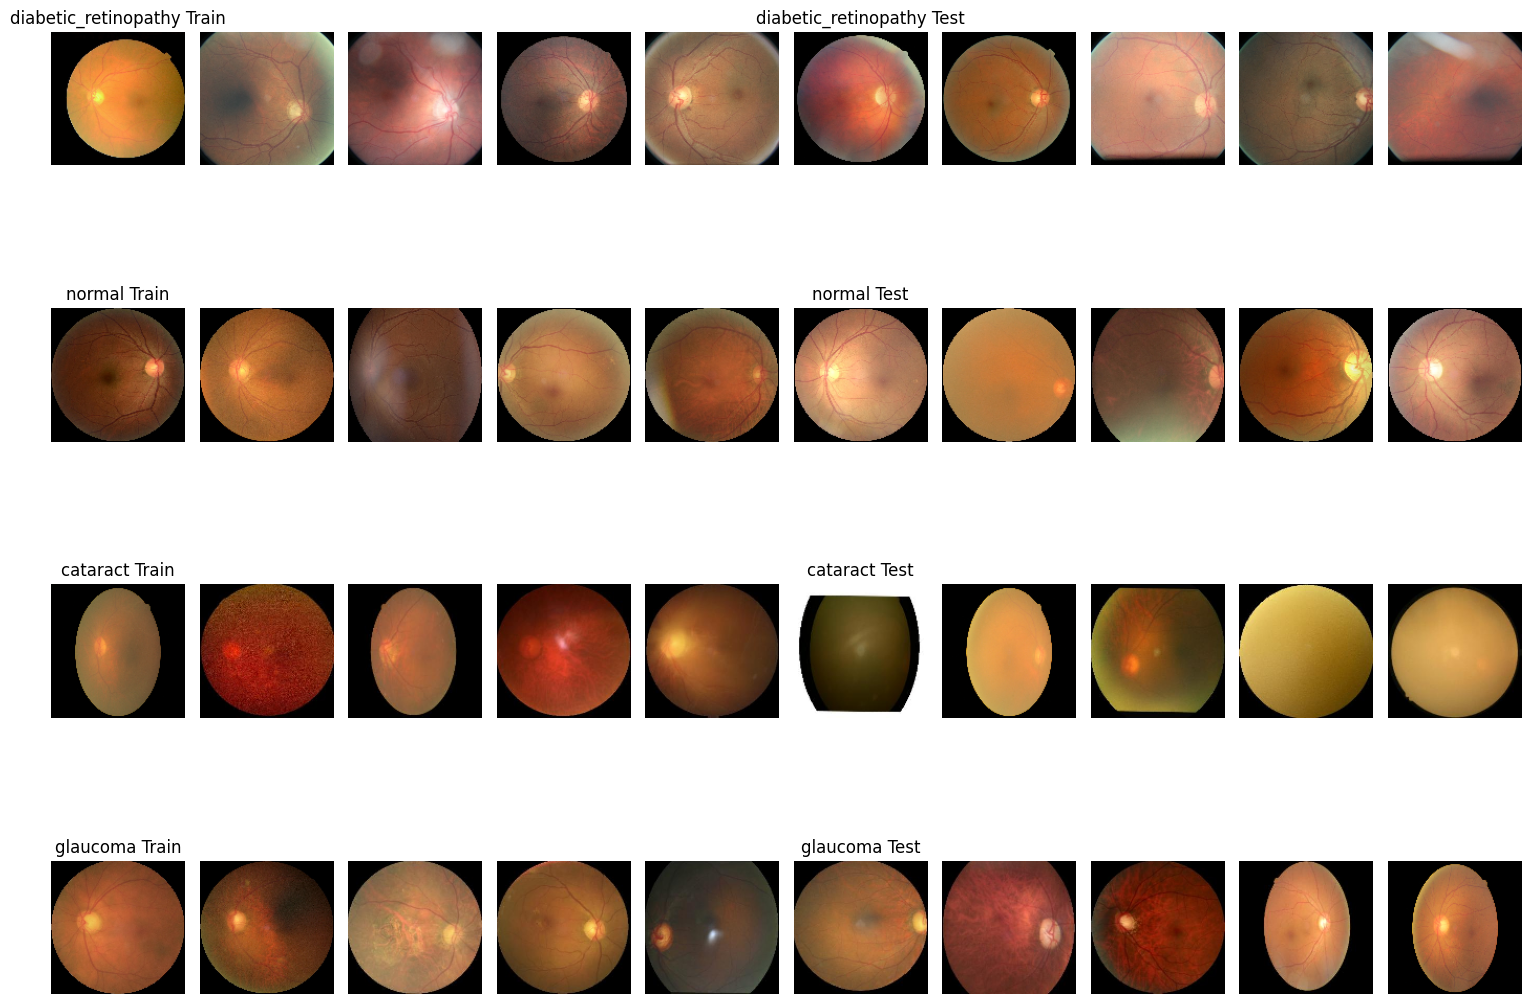

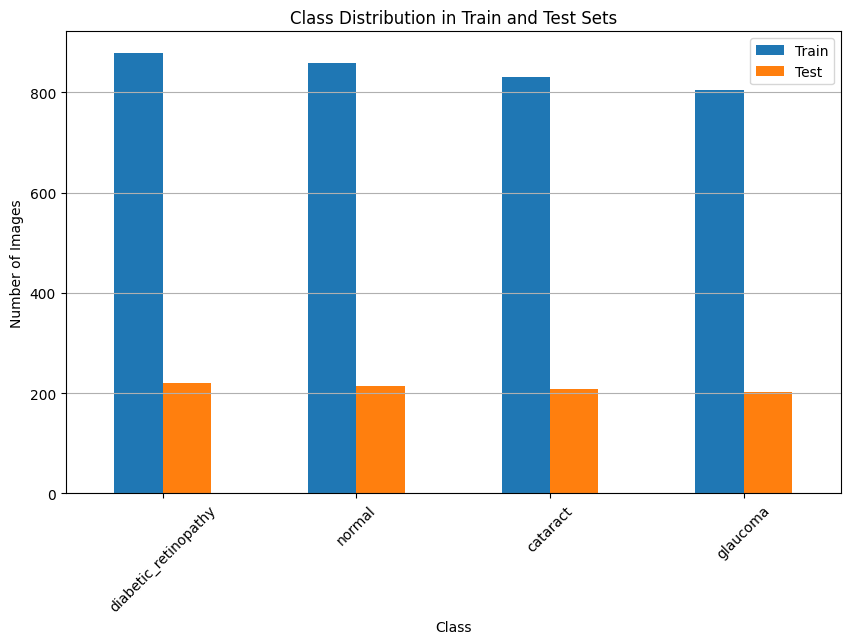

In [6]:
# 🖼️ Display first 5 images from each category
def display_first_five_images(train_dirs, test_dirs):
    print("📂 First 5 Images from Each Category (Train & Test):\n")

    num_categories = len(train_dirs)
    fig, axes = plt.subplots(num_categories, 10, figsize=(15, num_categories * 3))  # 10 columns: 5 for train, 5 for test

    for i, category in enumerate(train_dirs.keys()):
        print(f"🔸 Category: {category}")

        # Train Set
        for j, img_path in enumerate(train_dirs[category][:5]):
            img = load_img(img_path, target_size=(128, 128))
            axes[i, j].imshow(img)  # Columns 0-4 for train
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'{category} Train', fontsize=12)

        # Test Set (continue from the next column)
        for j, img_path in enumerate(test_dirs[category][:5]):
            img = load_img(img_path, target_size=(128, 128))
            axes[i, j + 5].imshow(img)  # Columns 5-9 for test
            axes[i, j + 5].axis('off')
            if j == 0:
                axes[i, j + 5].set_title(f'{category} Test', fontsize=12)

    plt.tight_layout()
    plt.show()

# Call the function to display the first 5 images from both Train and Test sets
display_first_five_images(train_dirs, test_dirs)


#  Plot class distribution
def plot_class_distribution(train_dirs, test_dirs, class_names):
    train_counts = {category: len(files) for category, files in train_dirs.items()}
    test_counts = {category: len(files) for category, files in test_dirs.items()}

    df_counts = pd.DataFrame({'Train': train_counts, 'Test': test_counts})
    df_counts.plot(kind='bar', figsize=(10, 6))
    plt.title('Class Distribution in Train and Test Sets')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

plot_class_distribution(train_dirs, test_dirs, class_names)


In [ ]:
#  LOAD PRE-TRAINED RESNET50 MODEL
def load_resnet50(input_shape=(224, 224, 3), trainability=False):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    preprocessor = tf.keras.applications.resnet50.preprocess_input
    for layer in base_model.layers:
        layer.trainable = trainability
    model = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)
    return model, preprocessor

model, preprocess_input = load_resnet50()


In [ ]:
#  FUNCTION TO EXTRACT FEATURES FROM IMAGES
def preprocess_and_extract_features(img_path, model, preprocess_input, img_size=(224, 224)):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array, verbose=0)
    return features.flatten()

#  FUNCTION TO EXTRACT & SAVE FEATURES
def extract_and_save_features(image_files, model, preprocess_input, output_dir, category):
    features_list = [preprocess_and_extract_features(img, model, preprocess_input) for img in image_files]
    os.makedirs(output_dir, exist_ok=True)
    np.save(f'{output_dir}/{category}_features.npy', np.array(features_list))

#  EXTRACT & SAVE FEATURES FROM DRIVE DATASET
for split_name, dirs in zip(['train', 'test'], [train_dirs, test_dirs]):
    for category, image_files in dirs.items():
        output_dir = f'{FEATURE_DIR}/ResNet50/{split_name}'
        extract_and_save_features(image_files, model, preprocess_input, output_dir, category)


In [ ]:
#  LOAD FEATURES FROM SAVED FILES
X_train, y_train, X_test, y_test = [], [], [], []
for category in class_names:
    train_features = np.load(f'{FEATURE_DIR}/ResNet50/train/{category}_features.npy')
    test_features = np.load(f'{FEATURE_DIR}/ResNet50/test/{category}_features.npy')
    X_train.append(train_features)
    y_train.append(np.full(train_features.shape[0], class_names.index(category)))
    X_test.append(test_features)
    y_test.append(np.full(test_features.shape[0], class_names.index(category)))

X_train, y_train = np.concatenate(X_train, axis=0), np.concatenate(y_train, axis=0)
X_test, y_test = np.concatenate(X_test, axis=0), np.concatenate(y_test, axis=0)


In [ ]:
#  COMPUTE CLASS WEIGHTS
def get_class_weight_dict(y_train):
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    return dict(zip(np.unique(y_train), class_weights))

class_weight_dict = get_class_weight_dict(y_train)

#  TRAIN MULTIPLE SGD CLASSIFIERS
loss_functions = ["log_loss", "hinge", "modified_huber", "squared_hinge", "perceptron"]
classifiers = []
for loss_function in loss_functions:
    clf = SGDClassifier(loss=loss_function, class_weight=class_weight_dict, max_iter=1000, learning_rate='adaptive', eta0=0.01, random_state=42)
    clf.fit(X_train, y_train)
    classifiers.append((loss_function, clf))

#  CREATE VOTING CLASSIFIER
voting_clf = VotingClassifier(estimators=classifiers, voting="hard")
voting_clf.fit(X_train, y_train)


In [ ]:
#  EVALUATE THE MODEL
y_pred = voting_clf.predict(X_test)

#  PRINT ACCURACY & CLASSIFICATION REPORT
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

#  CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for ResNet50 with Voting Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
#  SAVE MODEL
model_save_path = '/content/drive/MyDrive/voting_classifier_model.joblib'
joblib.dump(voting_clf, model_save_path)
print(f"Model saved at {model_save_path}")
